# Wikipedia mapping

In [17]:
#Load modules
from bs4 import BeautifulSoup
from itertools import compress
import requests
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

## Declare functions

In [18]:
#Get links from article
def get_internal_links(article):
    """
    Takes the name of a wikipedia article as input and returns all internal
    link the article refers to.
    --------------
    Input:  - article : String
             e.g. 'Python_(programming_language)'
    
    Output: - links   : List of Strings
             e.g. ['Guido_van_Rossum', 'Interpreted_language', 'XML', ...]
    """
    links = [] #Initialize an empty list of links
    url = 'https://en.wikipedia.org/wiki/' + article
    #Build the BeautifulSoup item
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    #Iterate over all links within the content of the wikipedia article
    for a in soup.find('div', {'id': 'mw-content-text'}).findAll('a'):
        href = a.get('href')
        if href is None: #Some links have an empty href, skip them
            continue
        elif href[:6] == '/wiki/': #This is an internal link to an article
            #Links with ':' are special links such as Files or BookSources
            #Disambiguation links also cause problems
            if not (':' in href in href or href[6:] in links or '(disambiguation)' in href):
                if not 'List_of_' in href: #Comment out to keep Lists of () articles
                    links.append(href[6:]) #Only append the name of the article
    return links

## Initialize variables and constants

In [19]:
#Variables
article = 'Metallica' #Starting article
searchFirst = 'depth' #'breadth' or 'depth' search

#Set a limit to the crawling
maxItems=10
maxBreadth=0
maxDepth=0
skip = False #Boolean used for depth-search only

itemCount = 0 #Initialize the item counter
links = get_internal_links(article)
network = {article:links} #Initialize the output dictionary
depth = {article: 1} #Initialize the depth dictionary, for maxDepth control
scraped = [] #List of fully scraped articles (all internal links have been scraped according to maxBreadth/Depth)
depth_scraped = [] #Similar list as above for depth-search only
depthSearch = (searchFirst=='depth') #Set the boolean to handle depth-first search


print('Variables declared: OK') #Temporary debug line

Variables declared: OK


## Crawl and collect links

In [20]:
#Main program
if maxBreadth > 0:
    links = links[:maxBreadth]
        
#Repeat this step until we reach the maxItems threshold
while itemCount <= maxItems:
    #Iterate over the keys who aren't fully scraped according to maxBreadth/Depth (nodes)
    if depthSearch:
        keys = [k for k in network.keys() if k not in depth_scraped]
        if len(keys)==0: #Max depth reached
            keys = [k for k in network.keys() if k not in scraped]
    else:
        keys = [k for k in network.keys() if k not in scraped]
    
    #We have scraped everything allowed by maxBreadth/Depth
    if len(keys)==0:
        break
    
    #Iterate over nodes that haven't been scraped
    for k in keys:
        if maxDepth == 0 or maxDepth > depth[k]:
            print('key :', k) #Temp debug line
            #Iterate over the values (edges / relationships / internal links)
            for v in get_internal_links(k):
                print(k, '-', 'Item', itemCount, ':', v) #Temp debug line
                if v not in network.keys(): #Add them to the keys if not present
                    links = get_internal_links(v) #Get the internal links
                    if maxBreadth == 0: #Set the max breadth as large as possible
                        maxBreadth = len(links)
                        mB = maxBreadth
                    #Special case for depth-first search
                    elif depthSearch:
                        mB = maxBreadth #Use np.isin() with numpy 1.13
                        while len(links[:mB]) - sum(np.in1d(links[:mB], list(network.keys()))) == 0:
                            mB += 1
                    else:
                        mB = maxBreadth
                    
                #Add the edge entry as a node 
                network[v] = links[:mB] #Only assign links up to maxBreadth
                depth[v] = depth[k] + 1 #Set the depth on the children-node
                itemCount += 1

                #Exit if we have reached the max item threshold
                if itemCount >= maxItems:
                    break
                if depthSearch:
                    depth_scraped.append(k) #Append the father-node to the special list
                    skip = True
                    break #Only add the first edge as a node
        if skip==True:
            skip = False
            break
        else:
            scraped.append(k) #The node doesn't have to be scraped again
            depth_scraped.append(k)
        if itemCount >= maxItems:
            break

key : Metallica
Metallica - Item 0 : Metallica_(album)
key : Metallica_(album)
Metallica_(album) - Item 1 : Album
key : Album
Album - Item 2 : Phonograph_record#78_rpm_disc_developments
key : Phonograph_record#78_rpm_disc_developments
Phonograph_record#78_rpm_disc_developments - Item 3 : Phonograph_Record_(magazine)
key : Phonograph_Record_(magazine)
Phonograph_Record_(magazine) - Item 4 : Music_magazine
key : Music_magazine
Music_magazine - Item 5 : Magazine
key : Magazine
Magazine - Item 6 : Quartering_(heraldry)
key : Quartering_(heraldry)
Quartering_(heraldry) - Item 7 : Impalement_(heraldry)
key : Impalement_(heraldry)
Impalement_(heraldry) - Item 8 : Quartering_(heraldry)
key : Metallica
Metallica - Item 9 : Metallica_(album)
key : Metallica_(album)
Metallica_(album) - Item 10 : Album


## Network and chart

The network has 245 nodes and 926 edges


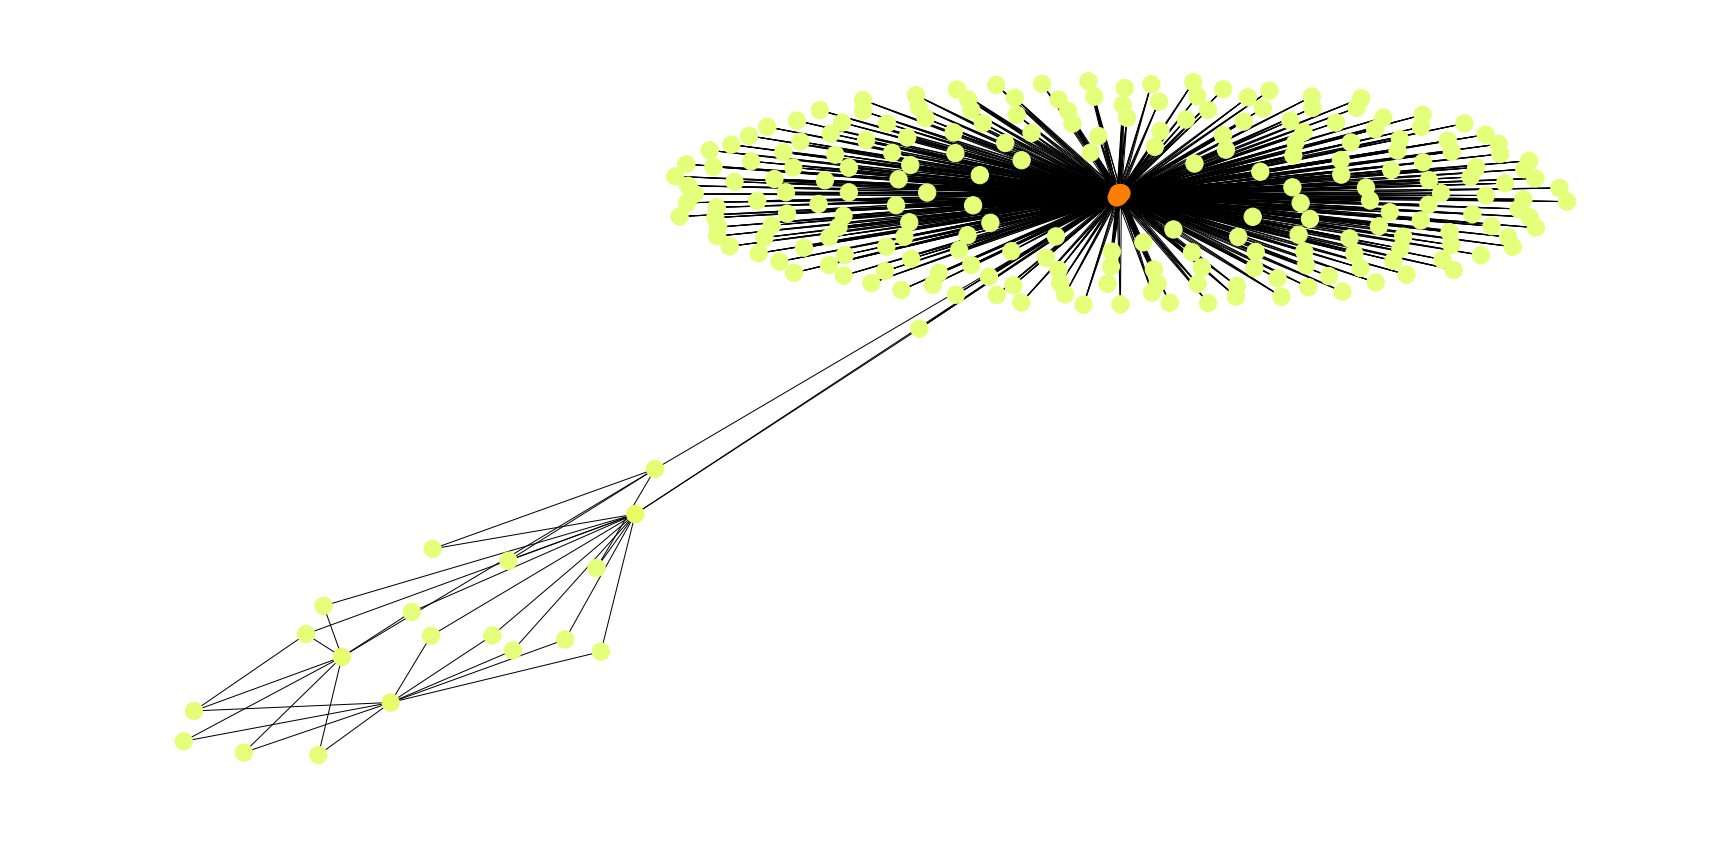

In [21]:
#Create network and chart
plotTitle = ''
with_labels=False
cmap='Wistia'

#Clean crawl data (we remove 'end-nodes', i.e. values that are not present in the keys or other values)
newData = network
for k1, v1 in network.items(): #Loop to discard nodes with only 1 edge
    msk = np.in1d(list(v1), list(network.keys())) #Keep values that are also nodes (keys)
    for k2, v2 in network.items():
        if k1 != k2:
            msk2 = np.in1d(list(v1), list(v2)) #Keep values, that have multiple nodes connections
            #OR-filter on msk, True if at least 1 is True, else False
            msk = [max(msk[i], msk2[i]) for i in range(len(v1))]
    newData[k1] = list(compress(v1, msk)) #Filter out items that don't belong to msk   


#Transform the data to a networkx Graph object
G = nx.Graph(network)
#Print the size of the network
print('The network has {} nodes and {} edges'.format(len(G.nodes()), len(G.edges())))

mapping = [] #Initialize output
for node in G.nodes():
    if node in network.keys():
        mapping.append(len(network[node])) #Append the count of values if the node is a key
    else:
        mapping.append(0) #0 if the node is not a key

plt.figure(figsize=(30,15)) #Set plot size
plt.title(plotTitle) #Set plot title
#Draw the graph (careful, can be very long)
nx.draw(G,
        node_color=mapping,
        with_labels=with_labels,
        cmap=cmap)